# Crude Oil Challenge
## About
This notebook presents my approach to the [crude oil challenge][1] proposed by Societe General.<br>
My current score on the leaderboard is 0.80, the regressor used being the RandomForestClassifier of sklearn.
<br><br> _NB:_ <br>
I created a Github repository for this project, that provides a better insight into the structure of my work. [Check it out][2] ! 
<br>

[1]: https://challengedata.ens.fr/en/challenge/25/predict_the_crude_oil_production_trend.html#
[2]: https://github.com/Edouard360/crude-oil-ml

## First Look Into The Data

In [8]:
import pandas as pd

train_df = pd.read_csv("../data/train.csv",delimiter=";",header=0,index_col=0);
train_label = pd.read_csv("../data/label.csv",delimiter=";",header=0,index_col=0);

What is the shape of the data ?

In [9]:
train_df.shape

(10159, 122)

### Handling the column names
We can identify columns groups from our data.

In [10]:
columns_group = [train_df.columns[2+10*i:2+10*(i+1)] for i in range(12)]
columns_group.insert(0,train_df.columns[0:2])

And that way, we have

In [11]:
columns_group[1]

Index(['1_diffClosing stocks(kmt)', '1_diffExports(kmt)', '1_diffImports(kmt)',
       '1_diffRefinery intake(kmt)', '1_diffWTI',
       '1_diffSumClosing stocks(kmt)', '1_diffSumExports(kmt)',
       '1_diffSumImports(kmt)', '1_diffSumProduction(kmt)',
       '1_diffSumRefinery intake(kmt)'],
      dtype='object')

In [12]:
columns_group[2]

Index(['2_diffClosing stocks(kmt)', '2_diffExports(kmt)', '2_diffImports(kmt)',
       '2_diffRefinery intake(kmt)', '2_diffWTI',
       '2_diffSumClosing stocks(kmt)', '2_diffSumExports(kmt)',
       '2_diffSumImports(kmt)', '2_diffSumProduction(kmt)',
       '2_diffSumRefinery intake(kmt)'],
      dtype='object')

Let's create useful functions to __operate on these columns__. For instance, we'd like to be able to get:

+ All the statistics for one period. Just like the columns_group[1] output.
+ All the statistics for many periods. The period set could be expressed like: `[1,2,3,4]` or `range(1,5)`.
+ The statistics for only one category ( like `'diffImports(kmt)'` ) over all the periods (period1 to period12).
+ The statistics for a list of categories ( like `['diffImports(kmt)','diffWTI','diffExports']` ) over all the periods.
+ The statistics for a list of categories ( like `['diffImports(kmt)','diffWTI','diffExports']` ) for some given periods ( like `range(4,8)` ).

The following lines of code provide these features.


In [13]:
COLUMNS_SUFFIX = ['_diffClosing stocks(kmt)',
                  '_diffExports(kmt)', '_diffImports(kmt)',
                  '_diffRefinery intake(kmt)', '_diffWTI',
                  '_diffSumClosing stocks(kmt)', '_diffSumExports(kmt)',
                  '_diffSumImports(kmt)', '_diffSumProduction(kmt)',
                  '_diffSumRefinery intake(kmt)']


def check_type_prefix(i):
    if (type(i) is int):
        i = [i]
    elif ((type(i) is not range) and (type(i) is not list)):
        raise TypeError("Only range, list or single integer allowed !")
    return i


def check_type_suffix(i):
    if (type(i) is str):
        i = [i]
    elif ((type(i) is not list)):
        raise TypeError("Only list or single string allowed !")
    return i


def get_prefix(i):
    i = check_type_prefix(i)
    return [str(j) + suffix for j in i for suffix in COLUMNS_SUFFIX]


def get_suffix(suffix_request, prefix=range(1, 13)):
    prefix = check_type_prefix(prefix)
    suffix_request = check_type_suffix(suffix_request)
    for i in range(len(suffix_request)):
        for original_suffix in COLUMNS_SUFFIX:
            if (str.lower(original_suffix).find(str.lower(suffix_request[i])) != -1):
                suffix_request[i] = original_suffix
                break
    suffix_request = list(set(suffix_request))
    return [str(j) + suffix for j in prefix for suffix in suffix_request]


Now we can simply use `get_prefix` and `get_suffix` that way:

+ All the statistics for one period. 

In [14]:
get_prefix(5)

['5_diffClosing stocks(kmt)',
 '5_diffExports(kmt)',
 '5_diffImports(kmt)',
 '5_diffRefinery intake(kmt)',
 '5_diffWTI',
 '5_diffSumClosing stocks(kmt)',
 '5_diffSumExports(kmt)',
 '5_diffSumImports(kmt)',
 '5_diffSumProduction(kmt)',
 '5_diffSumRefinery intake(kmt)']

+ All the statistics for many periods.

In [15]:
get_prefix(range(7,9))

['7_diffClosing stocks(kmt)',
 '7_diffExports(kmt)',
 '7_diffImports(kmt)',
 '7_diffRefinery intake(kmt)',
 '7_diffWTI',
 '7_diffSumClosing stocks(kmt)',
 '7_diffSumExports(kmt)',
 '7_diffSumImports(kmt)',
 '7_diffSumProduction(kmt)',
 '7_diffSumRefinery intake(kmt)',
 '8_diffClosing stocks(kmt)',
 '8_diffExports(kmt)',
 '8_diffImports(kmt)',
 '8_diffRefinery intake(kmt)',
 '8_diffWTI',
 '8_diffSumClosing stocks(kmt)',
 '8_diffSumExports(kmt)',
 '8_diffSumImports(kmt)',
 '8_diffSumProduction(kmt)',
 '8_diffSumRefinery intake(kmt)']

+ The statistics for only one category over all the periods. (Observe the leniency for the name of the feature).

In [16]:
get_suffix('Imports') # get_suffix('imports') and get_suffix('_diffImports(kmt)') give the same result.

['1_diffImports(kmt)',
 '2_diffImports(kmt)',
 '3_diffImports(kmt)',
 '4_diffImports(kmt)',
 '5_diffImports(kmt)',
 '6_diffImports(kmt)',
 '7_diffImports(kmt)',
 '8_diffImports(kmt)',
 '9_diffImports(kmt)',
 '10_diffImports(kmt)',
 '11_diffImports(kmt)',
 '12_diffImports(kmt)']

+ The statistics for a list of categories over all the periods. (Again, the function is lenient for the feature's names)

In [17]:
get_suffix(['Imports','Exports'])

['1_diffExports(kmt)',
 '1_diffImports(kmt)',
 '2_diffExports(kmt)',
 '2_diffImports(kmt)',
 '3_diffExports(kmt)',
 '3_diffImports(kmt)',
 '4_diffExports(kmt)',
 '4_diffImports(kmt)',
 '5_diffExports(kmt)',
 '5_diffImports(kmt)',
 '6_diffExports(kmt)',
 '6_diffImports(kmt)',
 '7_diffExports(kmt)',
 '7_diffImports(kmt)',
 '8_diffExports(kmt)',
 '8_diffImports(kmt)',
 '9_diffExports(kmt)',
 '9_diffImports(kmt)',
 '10_diffExports(kmt)',
 '10_diffImports(kmt)',
 '11_diffExports(kmt)',
 '11_diffImports(kmt)',
 '12_diffExports(kmt)',
 '12_diffImports(kmt)']

+ And finally, the statistics for a list of categories __for some given periods__.

In [18]:
get_suffix(['wti','refinery'],range(1,4))

['1_diffWTI',
 '1_diffRefinery intake(kmt)',
 '2_diffWTI',
 '2_diffRefinery intake(kmt)',
 '3_diffWTI',
 '3_diffRefinery intake(kmt)']

Now that we have tools for handling the columns let's move on ! 
<br><br>_NB:_<br> There is also a `except_suffix` function (that does what its name suggest).
[Github link][3] for the full code.

[3]: https://github.com/Edouard360/crude-oil-ml/blob/master/tools/features_name.py

## Dealing with missing values
We can explicit the columns where the missing values are located :

In [19]:
def discrimateColumns(train_df):
    describe_df = train_df.describe()
    columns_missing = train_df.columns[(describe_df.loc['count'] < len(train_df)).values]
    columns_full = train_df.columns[(describe_df.loc['count'] == len(train_df)).values]
    return (columns_missing,columns_full)
print("Columns where we find missing values :\n")
print(discrimateColumns(train_df)[0])
print("\nTotal number of missing values :\n")
print(train_df.isnull().sum().sum())

Columns where we find missing values :

Index(['1_diffClosing stocks(kmt)', '1_diffImports(kmt)',
       '2_diffClosing stocks(kmt)', '2_diffImports(kmt)',
       '3_diffClosing stocks(kmt)', '3_diffImports(kmt)',
       '4_diffClosing stocks(kmt)', '4_diffImports(kmt)',
       '5_diffClosing stocks(kmt)', '5_diffImports(kmt)',
       '6_diffClosing stocks(kmt)', '6_diffImports(kmt)',
       '7_diffClosing stocks(kmt)', '7_diffImports(kmt)',
       '8_diffClosing stocks(kmt)', '8_diffImports(kmt)',
       '9_diffClosing stocks(kmt)', '9_diffImports(kmt)',
       '10_diffClosing stocks(kmt)', '10_diffImports(kmt)',
       '11_diffClosing stocks(kmt)', '11_diffImports(kmt)',
       '12_diffClosing stocks(kmt)', '12_diffImports(kmt)'],
      dtype='object')

Total number of missing values :

4497


We could impute values simply by __choosing the median for each column__.<br>
Or we could __group with respect to the country and the month__ and then __impute the median__. 

In [45]:
# group = ["country","month"]
# train_df.ix[:,2:] = train_df.groupby(group,as_index=False).transform(lambda x: x.fillna(x.median()))[train_df.columns[2:]]

Yet, is is also very common to __fill the NAs with a preliminary regression__. 

In [20]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

def fillRegression(train_df):
    columns_missing,columns_full = discrimateColumns(train_df)
    for target_column in columns_missing:
        #print(target_column) # Uncomment this to see the progression
        X = train_df[columns_full].values
        y = train_df[target_column].values
        train_is = np.arange(len(y))[~np.isnan(y)]
        test_is = np.arange(len(y))[np.isnan(y)]
        clf = RandomForestRegressor(n_estimators=10, max_leaf_nodes=5)
        clf.fit(X[train_is], y[train_is])
        train_df.ix[test_is, target_column] = clf.predict(X[test_is])
        columns_full = np.append(columns_full, target_column)
    return train_df

train_df = fillRegression(train_df)

And we can now check that there are no missing values left:

In [21]:
print("\nTotal number of missing values :\n")
print(train_df.isnull().sum().sum())


Total number of missing values :

0


### Periodicity
 There is actually a __periodicity__ in the data. Of course, there are month, but we can specifically __recover their order__. <br>In this section we engineer a __`'period'` feature__, which ranges from 0 to about 140 for the train_df and corresponds to the:<br> `140 =~ (12 months) * (~11-12 years)`Of the train data. The period of the test data is __also recoverable__ and ranges until:<br>  `170 =~ (12 months) * (~14 years)` Which corresponds to the Societe Generale digits - _from 2002 to 2016_.<br> 
The code below can take any feature of reference as a input. It builds the dataframe which puts __the value taken by that feature__, side by side with __the period at which the feature took that value__. <br>
For the sake of simplicity, I have removed the comments from the function. [Github link][4] for the full code.

[4]: https://github.com/Edouard360/crude-oil-ml/blob/master/feature_extraction/time_period.py

In [22]:
def getFirstValue(X_df,suffix_feature):
    valuesSumImport = X_df[get_suffix(suffix_feature, 1)[0]].unique()
    for value in valuesSumImport:
        if (sum(X_df[get_suffix(suffix_feature, 2)[0]] == value) == 0):
            return value

def computePeriod(X_df, orderedValues,suffix_feature = "SumImports"):
    if(len(orderedValues)==0):
        orderedValues+=[getFirstValue(X_df,suffix_feature)]
    for columnNumber in [1, 11]:
        while True:
            prev_value = orderedValues[-1]
            array_next = list(set(X_df.ix[(X_df[get_suffix(suffix_feature, columnNumber)[0]] == prev_value), [
                get_suffix(suffix_feature, columnNumber + 1)[0]]].values.ravel()))
            if (len(array_next) == 0):
                break
            elif (len(array_next) != 1):
                raise ("There is not one unique value")
            orderedValues += [array_next[0]]

    index_feature = get_suffix(suffix_feature, 1)[0]
    period_df = pd.DataFrame(
        {index_feature: orderedValues, "period": range(0, len(orderedValues))}).set_index(index_feature)
    return period_df

And this gives us:

In [23]:
ordered_values = []
period_df = computePeriod(train_df,ordered_values)
period_df.head(5)

,period
1_diffSumImports(kmt),
-9230.9587,0
11014.4854,1
-3276.4590,2
5655.8990,3
-4455.1499,4


Which means that by merging `train_df` with that dataFrame on the `1_diffSumImports(kmt)` columns, we would add that __`'period'` feature__.

In [24]:
train_df = train_df.reset_index().merge(period_df, right_index=True, how='left',left_on='1_diffSumImports(kmt)').set_index('ID')

In [25]:
train_df['period'].head()

ID
ID00001     13
ID00002    128
ID00003     13
ID00004     67
ID00005     99
Name: period, dtype: int64

`ordered_values` now contains all the successive values taken by the `1_diffSumImports(kmt)` column.
With this in mind, we can call the same function on the test_df dataframe to create the __`'period'` feature__, and we can merge it similarly.

In [26]:
test_df = pd.read_csv("../data/test.csv",delimiter=";",header=0,index_col=0);
period_df_test = computePeriod(test_df,ordered_values)
test_df = test_df.reset_index().merge(period_df_test, right_index=True, how='left',left_on='1_diffSumImports(kmt)').set_index('ID')

Which obviously gives the same dataframe as before, but with __more periods__...

In [27]:
period_df_test.head()

,period
1_diffSumImports(kmt),
-9230.9587,0
11014.4854,1
-3276.4590,2
5655.8990,3
-4455.1499,4


In [28]:
print("train_df ranges until period:")
print(period_df.max())
print("\nWhereas test_df ranges until period:")
print(period_df_test.max())


train_df ranges until period:
period    144
dtype: int64

Whereas test_df ranges until period:
period    170
dtype: int64


#### Checking the effective continuity
Now we can take a quick look at the continuity of our data over the periods, to __check that everything is fine__. We arbitrarily select country number 1 and look at its `diffImports` at `t = 1` and `t = 2` for each period `p in range(130,139)`.<br>
The value at `t = 2` and `p` should be the value at `t = 1` and `p+1`.<br>
This is what we verify with the function call below:

In [29]:
def checkPeriodContinuity(train_df, test_df):
    def filterSort(X_df):
        return X_df[(X_df['country'] == 1)].sort_values(by=["period"]).set_index("period")

    def printLine(X_df_sorted):
        start_span = 130
        end_span = 138
        prefix = 1
        suffix = "_diffImports(kmt)"
        print(X_df_sorted.ix[start_span:end_span, [str(prefix) + suffix, str(prefix + 1) + suffix]])

    train_df_sorted = filterSort(train_df)
    test_df_sorted = filterSort(test_df)
    printLine(train_df_sorted)
    printLine(test_df_sorted)

checkPeriodContinuity(train_df, test_df)    

        1_diffImports(kmt)  2_diffImports(kmt)
period                                        
130                 12.125             -11.625
131                -11.625             -15.500
132                -15.500               0.000
133                  0.000              30.000
        1_diffImports(kmt)  2_diffImports(kmt)
period                                        
134                  30.00                1.00
135                   1.00               -4.75
136                  -4.75                4.75
137                   4.75              -31.00
138                 -31.00                0.00


This concludes this section. We now have a `period` feature that might not be directly useful, but that might be exploited later on.

### Classifying countries
#### Dummy Coding
The `'country'` feature could be dummy coded, just like below, but this might lead to too many features, and therefore too much noise and the risk of overfitting. (And the same could be done for months).

In [30]:
# train_df = pd.get_dummies(train_df, drop_first=False, columns=['month']) # This would add 12 entries
# train_df = pd.get_dummies(train_df, drop_first=False, columns=['country']) # This would add 76 entries

It may be more clever to separate them somehow. Having a look at the plot below, we can spot a tendency for the points. This plot indeed separate the countries that are exporters (vertical axis), from those that are importers (horizontal axis). It is logical that a country that exports crude oil has no interest in importing it, and vice versa.

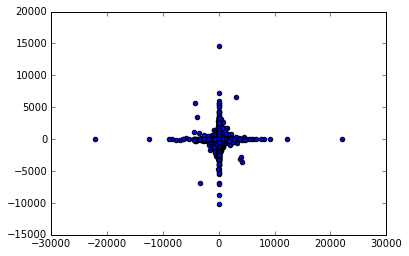

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(train_df['1_diffImports(kmt)'], train_df['1_diffExports(kmt)'])

The function below therefore creates a dataframe indexed on `'country'`, with a feature `'countryQuotient'` that separates countries into five categories, according to their ratio Imports/Exports.

In [34]:
def computeCountryQuotient(X_df):
    countrySum = dict()
    for columns_group in ['Imports', 'Exports']:
        countrySum[columns_group] = (abs(X_df[["country"] + get_suffix(columns_group)])).groupby("country").mean().mean(
            axis=1)

    return countrySum['Imports'] / countrySum['Exports']


def computeCategory(X_df):
    countryQuotient = computeCountryQuotient(X_df)
    threshold = 10
    countryQuotient = ((countryQuotient == np.inf) + 0) + ((countryQuotient >= threshold) + 0) + (
        (countryQuotient >= 1) + 0) \
                      + ((countryQuotient >= 1 / threshold) + 0) + ((countryQuotient > 0) + 0)
    countryQuotient = countryQuotient.astype('category')
    return pd.DataFrame.from_dict({"countryQuotient": countryQuotient})

country_df = computeCategory(train_df)
country_df.head()

,countryQuotient
country,
1.0,1
2.0,1
3.0,1
4.0,3
5.0,5


Merging `country_df` with `train_df` (and `test_df`) would therefore provide the whole dataframe with the `'countryQuotient'` feature.

## The FeatureExtractor object
 Before doing the regression, we have to choose which features to discard, to keep, or to create. This is why we need __a FeatureExtractor object__ that can do it __systematically__ for both `train_df` and `test_df`. 
The `TransformerMixin` from `sklearn` gives us the convenience to naturally call `fit_transform`.<br><br>
As seen before, we had to merge the `period_df` and `country_df` with `train_df` and `test_df`. This should therefore be done only once in the `transform` method of the `FeatureExtractor`. (=> See the for loop)<br><br>
At the end of the `transform` method is a selection of the features we want to keep, with `engineered_features` being an attribute of the `FeatureExtractor` object. It simply corresponds to the column names of the features we've engineered.


+ For `period_df` this would be `'1_diffSumImports(kmt)'`
+ For `country_df` this would be `'countryQuotient'`

The `registerEngineeredFeatures` method cares about automatically adding the features name in the `engineered_features` array, and indicates how to merge the dataframe containing that specific feature. Again, __that merge operation is performed in the transform__ function.<br>
Finally, note that the `mergeDf` function that simply does the merge we did before. It takes as a second parameter an object containing the information needed for the merge. 

In [35]:
from sklearn.base import TransformerMixin

def createFeatureExemple(X_df,engineered_features):
    engineered_features += ["Exports_10_11_12"]
    X_df[engineered_features[-1]] = X_df[get_suffix("exports", range(10,13))].sum(axis=1)
    return X_df

def mergeDf(X_df, engineered_df):
    X_df = X_df.reset_index().merge(engineered_df["data"], right_index=True, how='left',left_on=engineered_df['left_on'], left_index=engineered_df['left_index']).set_index('ID')
    return X_df

class FeatureExtractor(TransformerMixin):
    def __init__(self):
        self.ordered_values = []
        self.engineered_features = []
        self.engineered_df = dict()

    def fit(self, X_df, y):
        return self

    def registerEngineeredFeatures(self, feature_df, key, left_index=False, left_on='country'):
        self.engineered_features += list(feature_df.columns)
        self.engineered_features = list(set(self.engineered_features))
        self.engineered_df[key] = {'data': feature_df, 'left_on': left_on, 'left_index': left_index}

    def transform(self, X_df):
        self.registerEngineeredFeatures(computePeriod(X_df, self.ordered_values, suffix_feature="SumImports"), "period",
                                        left_on=get_suffix("SumImports", 1))
        
        for engineered_df in self.engineered_df.values():
            X_df = mergeDf(X_df, engineered_df)

        X_df = createFeatureExemple(X_df,self.engineered_features)
        X_df = X_df.ix[:,  get_suffix('sumprod',[11,12])+get_suffix(["exports",'refinery'],[10,11,12])+ self.engineered_features]
        return X_df

Above is an example of the creation of a feature in the `createFeatureExemple` method.<br>
For now, there is nothing in the `fit` method, but you can check the [Github link](https://github.com/Edouard360/crude-oil-ml/blob/master/feature_extraction/feature_extractor.py) for the full code.

In [36]:
extractor = FeatureExtractor()
train_df = extractor.fit_transform(train_df, train_label)
test_df = extractor.transform(test_df)

So that in the end we end up with these predictive features:

In [37]:
train_df.columns

Index(['11_diffSumProduction(kmt)', '12_diffSumProduction(kmt)',
       '10_diffRefinery intake(kmt)', '10_diffExports(kmt)',
       '11_diffRefinery intake(kmt)', '11_diffExports(kmt)',
       '12_diffRefinery intake(kmt)', '12_diffExports(kmt)', 'period',
       'Exports_10_11_12'],
      dtype='object')

## The Regressor
### Taking the metric into account
For assessing the strength of a model, we need a metric. The final score is based on auc (area under curve).<br>
Therefore, we can overwrite the `ClassifierMixin` of `sklearn` for a `ClassifierMixinAuc` that uses this metric.<br>
We then create the associated `RandomForestClassifierAuc`.

In [38]:
from sklearn.metrics import roc_auc_score
from sklearn.base import ClassifierMixin
from sklearn.ensemble import RandomForestClassifier

class ClassifierMixinAuc(ClassifierMixin):
    def score(self, X, y, sample_weight=None):
        return roc_auc_score(y,self.predict(X))

class RandomForestClassifierAuc(RandomForestClassifier,ClassifierMixinAuc):
    pass

### Another choice of regressor
We could also do our regression with the Gradient Boosting strategy. The `xgboost` library provides pretty powerful optimization parameters, and a convenient interface. To use it __within the `sklearn` environment__, and especially with the very useful `GridSearchCV` tool for cross validation, we need to __encapsulate__ it a little bit.

In [39]:
from sklearn.base import BaseEstimator,ClassifierMixin  
from sklearn.exceptions import NotFittedError
import xgboost as xgb
import numpy as np

class XGBRegressor(BaseEstimator,ClassifierMixinAuc):
    def __init__(self,colsample_bytree=1,subsample=1,max_depth=3,min_child_weight=6,gamma=0,eta=0.3,num_round = 20): #Important to put the parameters of the base estimator here !
        self.colsample_bytree = colsample_bytree
        # Subsample ratio of columns when constructing each tree.
        self.subsample = subsample
        # Subsample ratio of the training instance.
        # Setting it to 0.5 means that XGBoost randomly collected half of the data instances
        # to grow trees and this will prevent overfitting.
        self.eta = eta
        # Step size shrinkage used in update to prevents overfitting.
        # After each boosting step, we can directly get the weights of new features.
        # And eta actually shrinks the feature weights to make the boosting process more conservative.
        self.gamma = gamma
        # Minimum loss reduction required to make a further partition on a leaf node of the tree.
        # The larger, the more conservative the algorithm will be.
        self.min_child_weight = min_child_weight
        # Minimum sum of instance weight (hessian) needed in a child.
        self.max_depth = max_depth
        # Maximum depth of a tree
        self.num_round = num_round

    def fit(self,X,y):
        params = {"colsample_bytree": self.colsample_bytree,
                  "subsample":self.subsample,
                  "eta": self.eta,
                  "gamma" : self.gamma,
                  "min_child_weight": self.min_child_weight,
                  "max_depth":self.max_depth,
                  "silent":1,
                  'objective': 'binary:logistic'}
        self.regressor = xgb.train(params,xgb.DMatrix(X,y),num_boost_round=self.num_round)
        self.length = X.shape[1]

    @property
    def feature_importances_(self):
        if self.regressor is None:
            raise NotFittedError("Estimator not fitted, call `fit` before"
                                 " `feature_importances_`.")
        fscore = self.regressor.get_fscore()
        findexes = np.sort([int(s[1:]) for s in fscore.keys()])
        findexes_null = [i for i in range(0, self.length) if not any(findexes == i)]
        for findindex in findexes_null:
            fscore['f'+str(findindex)] = 0
        importance = np.array([fscore['f' + str(i)] for i in range(0, self.length)])
        importance = importance/importance.sum()
        return importance

    def predict(self, X):
        pred = self.regressor.predict(xgb.DMatrix(X))
        return (np.sign(pred - 0.5)) / 2 + 0.5

    def predict_proba(self, X):
        pred = self.regressor.predict(xgb.DMatrix(X))
        return np.array([1 - pred, pred]).T

## Cross validation
We want a __nice print__ of our regression results, either performed with:

+ A single regressor (`RandomForestClassifierAuc` or `XGBRegressor`) => `featureImportance` function.
+ Or with `GridSearchCV` finding the best parameters for our regressor => `fitStats` function.

In [40]:
def featureImportance(fit, train_df):
    '''
    Given the fit returned by the fit operation of a regressor,
    print the importance of the features and the correponding labels.
    :param fit:
    '''
    sorted_importance = fit.feature_importances_.argsort()[::-1]
    print("Numerical feature importance:")
    print(fit.feature_importances_[sorted_importance])
    print("Importance ranked features:")
    print(train_df.columns[sorted_importance])

def fitStats(fit):
    '''
    Given the fit returned by the fit operation of a GridSearch_CV,
    print some stats for assessing performance.
    :param fit:
    '''
    means = fit.cv_results_['mean_test_score']
    stds = fit.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, fit.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

# Summing up everything
To sum it all, our main.py file simply looks like this:

In [44]:
from sklearn.model_selection import GridSearchCV

test_df = pd.read_csv("../data/test.csv", delimiter=";", header=0, index_col=0);
train_df = pd.read_csv("../data/train_preprocessed.csv", delimiter=";", header=0, index_col=0);
train_label = pd.read_csv("../data/label.csv",delimiter=";", header=0, index_col=0);

extractor = FeatureExtractor()
train_df = extractor.fit_transform(train_df, train_label)
test_df = extractor.transform(test_df)

param_grid = dict(max_depth=[10], n_estimators=[15])
reg = GridSearchCV(RandomForestClassifierAuc(), param_grid=param_grid)
  
X_train = train_df.values
y_train = train_label.values.ravel()
X_test = test_df.values

fit = reg.fit(X_train, y_train)

fitStats(fit)
featureImportance(fit.best_estimator_, train_df)

# y_test = fit.predict_proba(X_test)[:,1]
# pred_label = pd.DataFrame(data={'Target': y_test},index=test_df.index)
# pred_label.to_csv("./output/label.csv",sep=";",quotechar="\"",quoting=2)

0.681 (+/-0.018) for {'max_depth': 10, 'n_estimators': 15}
Numerical feature importance:
[ 0.22586292  0.12504545  0.10049001  0.09915533  0.09649904  0.09408794
  0.07588203  0.0742592   0.06848579  0.04023229]
Importance ranked features:
Index(['12_diffSumProduction(kmt)', '12_diffExports(kmt)',
       '12_diffRefinery intake(kmt)', '11_diffSumProduction(kmt)',
       '10_diffExports(kmt)', 'Exports_10_11_12',
       '10_diffRefinery intake(kmt)', '11_diffRefinery intake(kmt)',
       '11_diffExports(kmt)', 'period'],
      dtype='object')


And the commented lines give the output file containing our prediction of the probability for an increase in crude oil production.
We can see the __auc score__ but also the __respective importance of the features__. That way we can choose which features to __remove__, __keep__, or __transform__. Everytime we want to edit the feature creation process, we can simply edit the FeatureExtractor object, run the program again, and see the improvements.<br>
[Link to the repository][7]

[7]: https://github.com/Edouard360/crude-oil-ml